In [146]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

In [147]:
X = np.load("Xtrain_Classification_Part1.npy")
X_TESTE = np.load("Xtest_Classification_Part1.npy")
Y = np.load("Ytrain_Classification_Part1.npy")

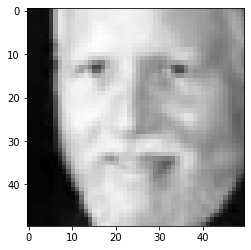

In [148]:
X = X.reshape(X.shape[0], 50, 50,1) / 255
Y = Y.reshape(Y.shape[0], 1)

plt.imshow(X[98], cmap="gray")
plt.show()

In [149]:
X = X.reshape(X.shape[0], 1, 50, 50)

X_tensor = torch.Tensor(X).float()
Y_tensor = torch.Tensor(Y).float()

#split the data
trainX, testX, trainY, testY = train_test_split(X_tensor, Y_tensor)

#convert to pytorch data
trainX = TensorDataset(trainX, trainY)
testX = TensorDataset(testX, testY)

trainLoader = DataLoader(trainX)
testLoader = DataLoader(testX)

In [150]:
def createGervasio():
    class gervasio(nn.Module):
        def __init__(self) -> None:
            super().__init__()

            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            size = np.floor((np.floor((50 + 2 * 1 - 5) / 1) + 1) / 2)
            
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            size = np.floor((np.floor((size + 2 * 1 - 5) / 1) + 1) / 2)

            expectSize = np.floor((size + 2 * 0 - 1) / 1) + 1
            expectSize = 20 * int(expectSize ** 2)

            self.fc1 = nn.Linear(expectSize, 50)

            self.out = nn.Linear(50, 1)

        def forward(self, x):
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            
            x = F.relu(F.max_pool2d(self.conv2(x),2))

            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))

            x = F.relu(self.fc1(x))

            x = torch.sigmoid(self.out(x))
            
            return x

    # criar o gervasio
    Gervasio = gervasio()

    # loss func
    lossF = nn.BCELoss()  # binary cross entropy with logits

    optimizer = torch.optim.Adam(Gervasio.parameters(), lr=0.001)

    return Gervasio, lossF, optimizer


In [151]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createGervasio()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X_for,y_for in trainLoader:

      # forward pass and loss
      y_forHat = net(X_for)
      loss = lossfun(y_forHat,y_for)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_forHat,axis=1) == y_for     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X_with,y_with = next(iter(testLoader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      y_withHat = net(X_with)
      print(y_withHat, y_with, y_with - y_withHat)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(y_withHat,axis=1)==y_with).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


tensor([[0.9914]]) tensor([[1.]]) tensor([[0.0086]])
tensor([[0.9955]]) tensor([[1.]]) tensor([[0.0045]])
tensor([[0.9984]]) tensor([[1.]]) tensor([[0.0016]])
tensor([[0.9991]]) tensor([[1.]]) tensor([[0.0009]])
tensor([[0.9996]]) tensor([[1.]]) tensor([[0.0004]])
tensor([[0.9998]]) tensor([[1.]]) tensor([[0.0002]])
tensor([[0.9995]]) tensor([[1.]]) tensor([[0.0005]])
tensor([[1.0000]]) tensor([[1.]]) tensor([[2.7418e-05]])
tensor([[0.9997]]) tensor([[1.]]) tensor([[0.0003]])
tensor([[1.0000]]) tensor([[1.]]) tensor([[9.8944e-06]])


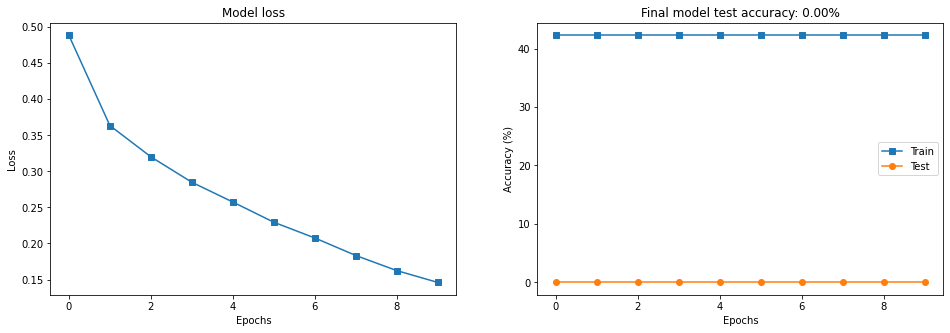

In [152]:
trainAcc,testAcc,losses,net = function2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()